In [1]:
! pip install tokenizers
! pip install transformers
!pip install bert-for-tf2


     |████████████████████████████████| 2.9MB 5.4MB/s 
     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 890kB 45.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b414fe95f1ec585f6dea13edff2311c399d960fcad8ca1d6c8043897f6dec465
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30537 sha256=e2adde73d4fb3a8c3a41a87466756a0531ca63c78d48a9489b7edaea0ff2b120
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7303 sha256=395bbcdbfb29b8330823579a52b93d71f26c7269f491d6a62acdf9c400c61737
  Stored in directory: /root/.cache/pip/wheels/67/f5/19

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras import layers
from keras.layers import Input
from keras import optimizers
import matplotlib.pyplot as plt
import csv
!pip install bert-for-tf2
import bert


In [3]:
np.random.seed(80)

In [10]:
from google.colab import files
uploaded = files.upload()

Saving inputs.csv to inputs.csv


In [11]:
df_in = pd.read_csv('inputs.csv', na_values="NONE" )
df_target = pd.read_csv('outputs.csv', na_values="NONE" )

# df_target = pd.read_csv('class_output.csv', na_values="NONE" ) 



IN_X1=df_in.to_numpy()
IN_Y1=df_target.to_numpy()

print(IN_X1.shape)
print(IN_Y1.shape)
w=np.where(IN_Y1<1291657)
IN_Y2=IN_Y1[w[0]]
IN_X=IN_X1[w[0]]

IN_Y=IN_Y2 #np.copy(IN_Y2)/np.max(IN_Y2)




feat_dim = 28 #Feature size

(483537, 30)
(483537, 1)


In [ ]:
print(df_in.shape)

(39850, 30)


In [73]:
import keras

X_train_full, X_test, y_train_full, y_test = train_test_split(
    IN_X.reshape((-1,feat_dim+2)), IN_Y.reshape((-1,1)), test_size=0.1, random_state=2)



X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=2)

# y_train = keras.utils.to_categorical(y_train) 
# y_valid= keras.utils.to_categorical(y_valid) 
# y_test= keras.utils.to_categorical(y_test) 


In [74]:
#Data standardizing!

scaler = StandardScaler()
X_train[:,2:] = scaler.fit_transform(X_train[:,2:])
X_valid[:,2:] = scaler.transform(X_valid[:,2:])
X_test[:,2:] = scaler.transform(X_test[:,2:])

y_train = scaler.fit_transform(y_train) 
y_valid = scaler.fit_transform(y_valid) 
y_test = scaler.fit_transform(y_test) 

In [62]:
y_train[0]

array([-0.25417426])

In [63]:
# import tensorflow as tf
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
# text_ds = tf.data.Dataset.from_tensor_slices(X_train[:,0]).batch(512)
# vectorizer.adapt(text_ds)

In [64]:
# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))

In [65]:
# path_to_glove_file = "./glove.6B.300d.txt"

# embeddings_index = {}
# with open(path_to_glove_file) as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         embeddings_index[word] = coefs

# print("Found %s word vectors." % len(embeddings_index))

In [66]:
# num_tokens = len(voc) + 2
# embedding_dim = 300
# hits = 0
# misses = 0

# # Prepare embedding matrix
# embedding_matrix = np.zeros((num_tokens, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in embedding index will be all-zeros.
#         # This includes the representation for "padding" and "OOV"
#         embedding_matrix[i] = embedding_vector
#         hits += 1
#     else:
#         misses += 1
# print("Converted %d words (%d misses)" % (hits, misses))

In [67]:
import tensorflow_hub as hub

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case) 

In [75]:
def tokenize_reviews(text_reviews):
    # text_reviews
    # print(tokenizer.tokenize(text_reviews))
    # print(tokenizer.tokenize(text_reviews))
    try:
      out=tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))
    except:
      out=[0]
    return out

x_str = [tokenize_reviews(commit_msg) for commit_msg in X_train[:,1]]
# X_train[1]

In [76]:
max_length=200

for i in range(len(x_str)):
  if (len(x_str[i]) <max_length):
    #padding
    x_str[i].extend([0]*(max_length-len(x_str[i])))
  else:
    x_str[i] = x_str[i][:max_length]



In [77]:
from tensorflow.keras.layers import Embedding

VOCAB_LENGTH = len(tokenizer.vocab)
embedding_layer = Embedding(
    VOCAB_LENGTH,
    max_length,
    embeddings_initializer=keras.initializers.RandomUniform(),#keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
def Reg_With_commit():
    inputs = Input(shape=(feat_dim, 1))
    inputB = Input(shape=(200))

    y = embedding_layer(inputB)
    # y = layers.BatchNormalization()(inputB)
  # model_glove.add(Conv1D(64, 5, activation='relu')) 
  # model_glove.add(MaxPooling1D(pool_size=4))
    y = layers.Dropout(0.5)(y)
    y = layers.Conv1D(256, 1, activation="relu")(y)
    y = layers.MaxPooling1D(pool_size=4)(y)
    y = layers.Dense(128, activation="relu")(y)
    y = layers.Flatten()(y)
    y = layers.Dense(128, activation="relu")(y)
    y = layers.BatchNormalization()(y)

    # y = Model(inputs=inputB, outputs=y)

    x = layers.BatchNormalization()(inputs)
    x = layers.LSTM(64, batch_input_shape=(None, feat_dim, 1),return_sequences=True)(x)
    x = layers.LSTM(64,return_sequences=True)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.LSTM(64,return_sequences=False)(x)
    x = layers.Dense(16)(x)
    x = layers.BatchNormalization()(x)

    # x = Model(inputs=inputs, outputs=x)


    combined = layers.concatenate([x, y],axis=-1)
    z = layers.Dense(1, activation="relu")(combined)

    model = Model(inputs=[inputs, inputB], outputs=z)
    return model

def Reg_With_features():
    inputs = Input(shape=(feat_dim, 1))

    x = layers.BatchNormalization()(inputs)
    x = layers.LSTM(128, batch_input_shape=(None, feat_dim, 1),return_sequences=True)(x)
    x = layers.LSTM(64,return_sequences=True)(x)
    x = layers.LSTM(32,return_sequences=False)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(1)(x)
    x = Model(inputs=inputs, outputs=x)


    return x


In [79]:
#with commit message

import keras
import tensorflow.keras.backend as K
import torch

print(np.array(x_str).shape)
R_model_H = Reg_With_commit()


R_opt = optimizers.Adam(lr=1E-5)
# R_opt = optimizers.RMSprop(lr=1E-3, epsilon=1e-08,decay=0.8E-6)
R_model_H.trainable = True
R_model_H.compile(optimizer=R_opt, loss='mean_squared_error')

x_num = K.constant(X_train[:,2:])

history = R_model_H.fit(x=[x_num,np.array(x_str)],y=y_train,epochs=200,batch_size=512,validation_split=0.05)

(389064, 200)
Epoch 1/200
722/722 [==============================] - 85s 113ms/step - loss: 1.0700 - val_loss: 0.9775
Epoch 2/200
722/722 [==============================] - 79s 109ms/step - loss: 0.9546 - val_loss: 0.9543
Epoch 3/200
722/722 [==============================] - 80s 111ms/step - loss: 0.9104 - val_loss: 0.9359
Epoch 4/200
722/722 [==============================] - 80s 111ms/step - loss: 0.9035 - val_loss: 0.9285
Epoch 5/200
722/722 [==============================] - 80s 111ms/step - loss: 0.8935 - val_loss: 0.9176
Epoch 6/200
722/722 [==============================] - 80s 111ms/step - loss: 0.8656 - val_loss: 0.9145
Epoch 7/200
722/722 [==============================] - 80s 111ms/step - loss: 0.8569 - val_loss: 0.9135
Epoch 8/200
722/722 [==============================] - 80s 111ms/step - loss: 0.8472 - val_loss: 0.9035
Epoch 9/200
722/722 [==============================] - 80s 111ms/step - loss: 0.8239 - val_loss: 0.9054
Epoch 10/200
722/722 [============================

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 200)     6104400     input_44[0][0]                   
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 28, 1)        4           input_43[0][0]                   
___________________________________________________________________________________________

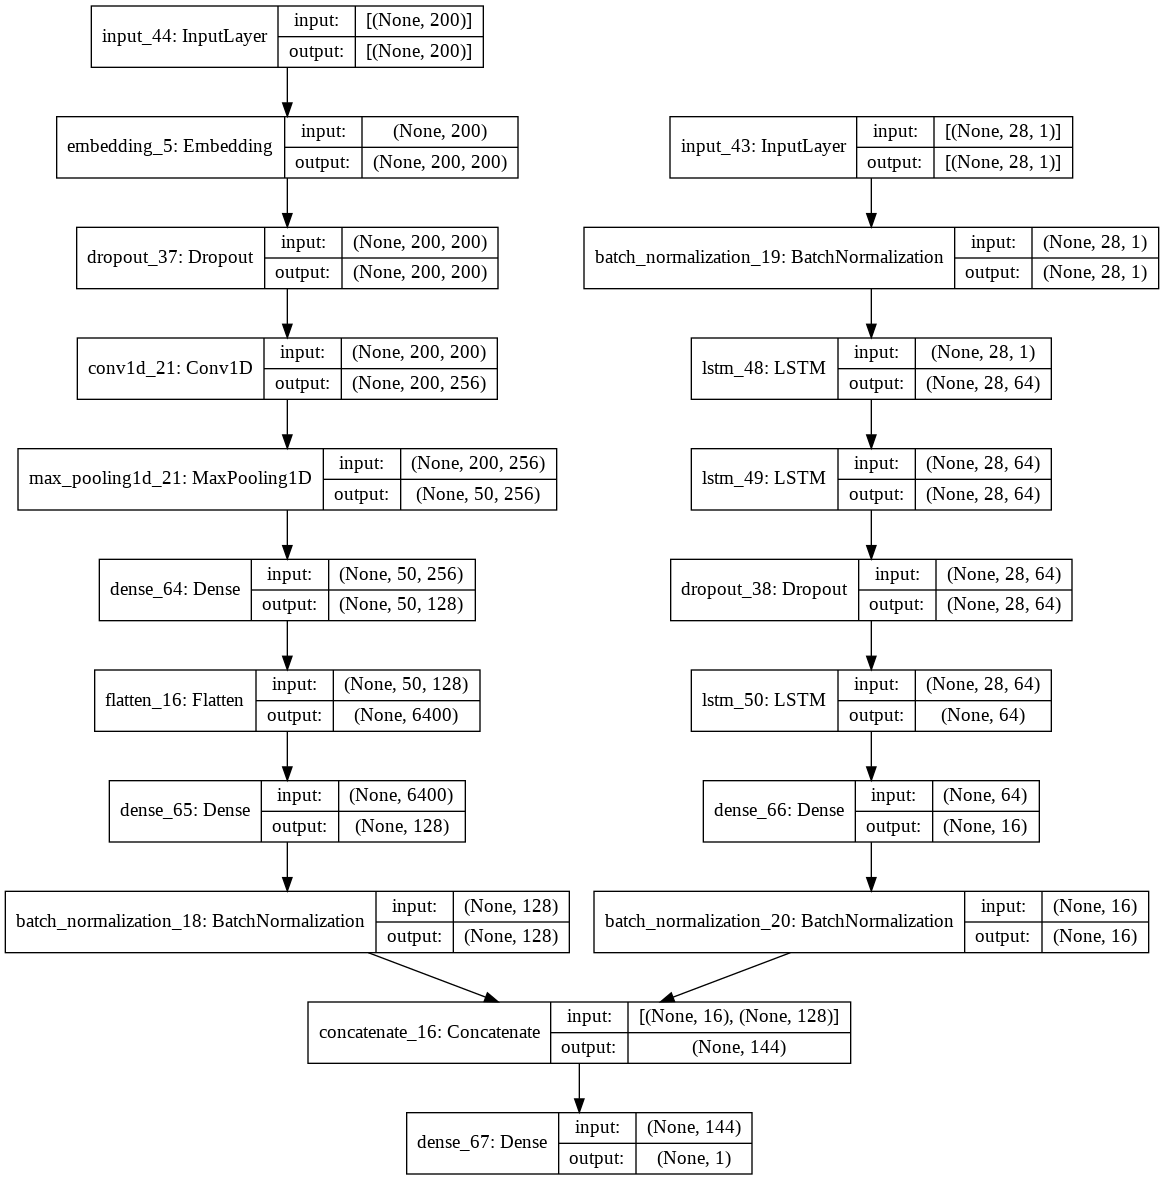

In [80]:
R_model_H.summary()
from keras.utils.vis_utils import plot_model
plot_model(R_model_H,  show_shapes=True, show_layer_names=True)

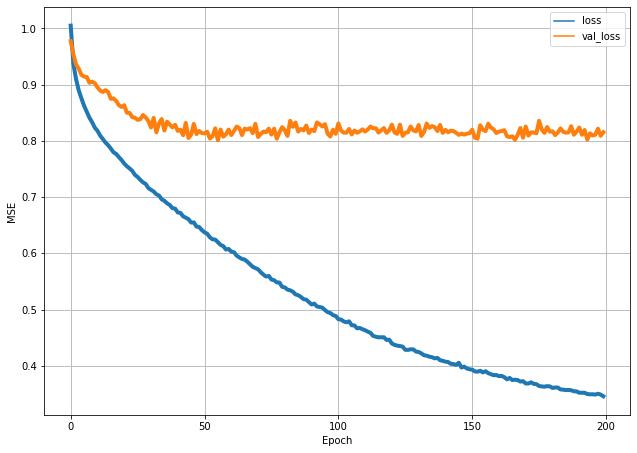

In [86]:
lws = [4, 4]
ax=pd.DataFrame(history.history).plot(figsize=(8, 5))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i])

plt.grid(True)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.rc('font', size=25)
plt.rc('axes', titlesize=25)
fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
fig.savefig('MSE.png', dpi=600,bbox_inches = 'tight')
plt.show()


In [82]:
#evaluation
from sklearn.metrics import r2_score

x_num_valid = K.constant(X_valid[:,2:])
x_str_valid = [tokenize_reviews(commit_msg) for commit_msg in X_valid[:,1]]

for i in range(len(x_str_valid)):
  if (len(x_str_valid[i]) <max_length):
    #padding
    x_str_valid[i].extend([0]*(max_length-len(x_str_valid[i])))
  else:
    x_str_valid[i] = x_str_valid[i][:max_length]

o_valid_hat=R_model_H.predict(x=[x_num_valid,np.array(x_str_valid)])

coefficient_of_dermination = r2_score(y_valid, o_valid_hat)
print(coefficient_of_dermination)

0.1831961923991754


In [83]:

ybar = np.sum(y_valid)/len(y_valid) 

In [84]:
ssreg = np.sum((o_valid_hat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y_valid - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
print(ssreg / sstot)

0.1662564562008443


In [ ]:
#evaluation
from sklearn.metrics import r2_score

x_num_test = K.constant(X_test[:,2:])

x_str_test = [tokenize_reviews(commit_msg) for commit_msg in X_test[:,1]]
print(x_num_test.shape)
for i in range(len(x_str_test)):
  if (len(x_str_test[i]) <max_length):
    #padding
    x_str_test[i].extend([0]*(max_length-len(x_str_test[i])))
  else:
    x_str_test[i] = x_str_test[i][:max_length]

print(np.array(x_str_test).shape)

o_test_hat=R_model_H.predict(x=[x_num_test,np.array(x_str_test)])
coefficient_of_dermination_test = r2_score(y_test, o_test_hat)
print(coefficient_of_dermination_test)

In [ ]:
ybar = np.sum(y_test)/len(y_test) 
ssreg = np.sum((o_test_hat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y_test - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
print(ssreg / sstot)